<a href="https://colab.research.google.com/github/ANJALICA/Python/blob/master/random_forest_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#Essential Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import os
import pickle
import csv
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
in_path = '/content/gdrive/My Drive/demo/chest_xray/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
#Reading and preparing the images
images = []
labels = []
limit=400
img_size=256

main_path='/content/gdrive/My Drive/demo/chest_xray/train'
folder_names = []
for entry_name in os.listdir('/content/gdrive/My Drive/demo/chest_xray/train'):
    entry_path = os.path.join('/content/gdrive/My Drive/demo/chest_xray/train', entry_name)
    if os.path.isdir(entry_path):
        folder_names.append(entry_name)
        
print('The Categories are',folder_names)

j=0
for folder in folder_names:
    for filename in os.listdir(os.path.join(main_path,folder)):
        img_path = os.path.join(main_path,folder)
        img = cv2.imread(os.path.join(img_path,filename)) 
        if img is not None:
            img  = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)   
            img = cv2.resize(img,(img_size, img_size))
            images.append(img)
            if folder == 'NORMAL':
                labels.append(0)
                #print('normal')
            else:
                labels.append(1)
                #print('PNE')
        j=j+1
        if j >= limit:
            j=0
            break
            
images,labels=np.array(images),np.array(labels)
print(images.shape)
#print(labels)

The Categories are ['NORMAL', 'PNEUMONIA']
(800, 256, 256)


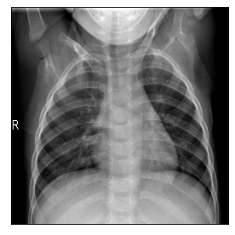

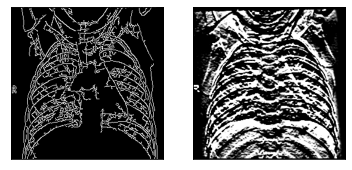

In [44]:
#Printing a random sample
from random import randrange

i = randrange(limit*2)

plt.imshow(images[i],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

#Canny
canny = cv2.Canny(images[i],40,200)


#Sobel
sobelY = cv2.Sobel(images[i],cv2.CV_8UC1,0,1,ksize=5)

preview = [canny,sobelY]
i=0
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(preview[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [0]:
#Obtaining Variance of images
kernel = np.ones((3,3),np.uint8)
var_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    var_vector[i] = np.var(x)
    i=i+1
#print(var_vector[6])

In [0]:
#Obtaining Mean of images
mean_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    mean_vector[i] = np.mean(x)
    i=i+1
#print(mean_vector)

In [0]:
#Obtaining Standard Deviation of images
std_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    std_vector[i] = np.std(x)
    i=i+1
#print(std_vector)

In [0]:
#Obtaining Skewness of images
skew_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    skew_vector[i] = stats.skew(x)
    i=i+1
#print(skew_vector)

In [0]:
#Obtaining Kurtosis of images
kurto_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    kurto_vector[i] = stats.kurtosis(x)
    i=i+1
#print(kurto_vector)

In [0]:
#Obtaining Entropy of images
entropy_vector = np.empty((limit*2,1))
i = 0
for image in images:
    x, bins = np.histogram(image,bins=255, density=False)
    entropy_vector[i] = stats.entropy(x)
    i=i+1
#print(entropy_vector)

In [0]:
#Applying Canny edge detection
canny_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    canny = cv2.Canny(image,40,200)
    canny_vector[i] = np.array(canny.flatten())
    i=i+1
#print(canny_vector[1])

In [0]:
#Applying Sobel X
sobelX_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    sobelX = cv2.Sobel(image,cv2.CV_8UC1,1,0,ksize=5)
    sobelX_vector[i] = np.array(sobelX.flatten())
    i=i+1

In [0]:
#Applying Sobel Y
sobelY_vector = np.empty((limit*2,img_size*img_size))
i = 0
for image in images:
    sobelY = cv2.Sobel(image,cv2.CV_8UC1,0,1,ksize=5)
    sobelY_vector[i] = np.array(sobelY.flatten())
    i=i+1

In [0]:
feature_vector = np.empty((limit*2,0))
feature_vector=np.append(feature_vector,mean_vector,axis=1)
feature_vector=np.append(feature_vector,var_vector,axis=1)
feature_vector=np.append(feature_vector,std_vector,axis=1)
feature_vector=np.append(feature_vector,skew_vector,axis=1)
feature_vector=np.append(feature_vector,kurto_vector,axis=1)
feature_vector=np.append(feature_vector,entropy_vector,axis=1)
feature_vector=np.append(feature_vector,canny_vector,axis=1)
feature_vector=np.append(feature_vector,sobelX_vector,axis=1)
feature_vector=np.append(feature_vector,sobelY_vector,axis=1)
#print(feature_vector[0])

In [58]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(feature_vector,labels,test_size=0.2,shuffle=True)#80% training

print(xtrain.shape)

(640, 196614)


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

RF=RandomForestClassifier(max_depth=10,n_estimators=150)
RF.fit(xtrain,ytrain)

ypredict = RF.predict(xtest)

print(RF.score(xtest,ytest))


print(classification_report(ytest,ypredict))

0.8875
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        86
           1       0.88      0.88      0.88        74

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



In [0]:
def plot_roc(name, clf, y_test, X_test):
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
   #plt.savefig('Log_ROC')
    plt.show()
    return fpr, tpr, thresholds

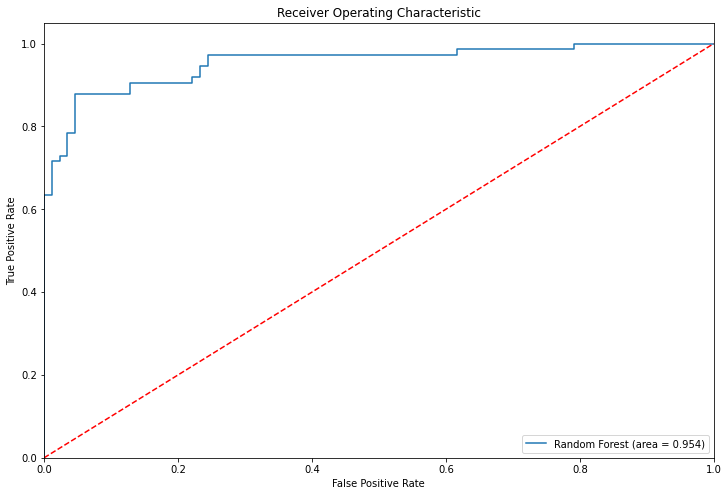

In [61]:
%matplotlib inline
# set some nicer defaults for matplotlib
from matplotlib import rcParams

from sklearn.metrics import roc_curve, roc_auc_score, auc

rcParams['figure.figsize'] = (12, 8)
rf_fpr, rf_tpr, rf_thresholds = \
                plot_roc("Random Forest", RF,ytest,xtest)

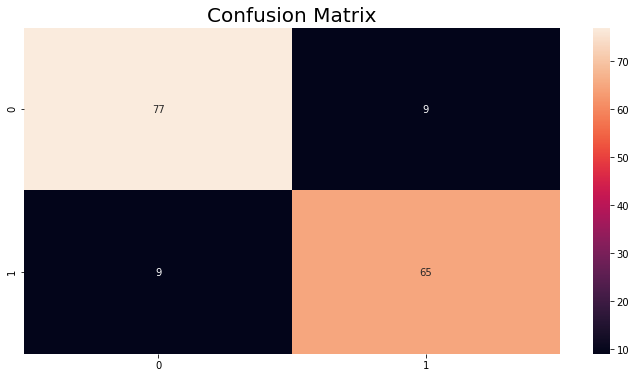

In [62]:
cm = confusion_matrix(ytest, ypredict)

plt.rcParams['figure.figsize'] = (12, 6)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, \
                            classification_report, precision_score, fbeta_score

acc=accuracy_score(ypredict, ytest)
print ("ACCURACY SCORE :" , acc)

ACCURACY SCORE : 0.8875


In [64]:
pre=precision_score(ypredict,ytest)
print("PRECISION SCORE :",pre)

PRECISION SCORE : 0.8783783783783784


In [65]:
re=recall_score(ypredict,ytest)
print("RECALL SCORE :",re)

RECALL SCORE : 0.8783783783783784


In [66]:
F1  = 2*pre*re/(pre+re)
print ("F1 SCORE:",F1)


F1 SCORE: 0.8783783783783784
